# SLO Plots

In [1]:
import os
from plot_goodput import read_data, plot_goodput_vs_slo
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

def run_and_plot(exp_name):
    os.system(f"python run_goodput_experiments.py {exp_name}")
    # print(os.popen(f'python run_goodput_experiments.py {exp_name}').read())
    result_file = f"res_{exp_name}.tsv"
    result_plot = f"fig_{exp_name}.pdf"
    data = read_data(result_file)
    plot_goodput_vs_slo(data, result_plot, True)

In [ ]:
run_and_plot("gamma_2")

In [ ]:
run_and_plot("gamma_2_long_slos")

In [ ]:
run_and_plot("gamma_2_short_slos_no_ilp")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp")

In [ ]:
experiments = [
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.0",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.05",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.1",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.15",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.2",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.25",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.3",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.35",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.4",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.45",
    "gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.5",
]
for experiment in experiments:
    run_and_plot(experiment)

In [ ]:
datasets = [
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.0.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.05.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.1.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.15.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.2.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.25.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.3.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.35.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.4.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.45.tsv",
    "res_gamma_2_long_slos_no_ilp_duration_400_pipeline_overhead_1.5.tsv",
]

data = {}
for dataset in datasets:
    data[dataset] = read_data(dataset)
sr_data = data[datasets[0]]["sr"]
data = {"mp_" + k.split(".tsv")[0].split("_")[-1]: data[k]["mp"] for k in datasets}
data["sr"] = sr_data

In [ ]:
color_dict = {
    "mp_1.0": "#1f77b4ff",
    "mp_1.05": "#1f77b4ef",
    "mp_1.1": "#1f77b4df",
    "mp_1.15": "#1f77b4cf",
    "mp_1.2": "#1f77b4bf",
    "mp_1.25": "#1f77b4af",
    "mp_1.3": "#1f77b49f",
    "mp_1.35": "#1f77b48f",
    "mp_1.4": "#1f77b47f",
    "mp_1.45": "#1f77b46f",
    "mp_1.5": "#1f77b45f",
    "sr": "C1"
}

def plot_goodput_vs_slo_many(data, output, show):
    fig, ax = plt.subplots()
    figure_size = (4, 4)

    methods = list(data.keys())
    # methods.sort(key=lambda x: method2order(x))

    curves = []
    legends = []
    x_max = 0
    y_max = 0
    for method in methods:
        curve = data[method]
        xs, ys = zip(*curve.items())
        ys = np.array(ys) * 100
        curve = ax.plot(xs, ys, color=color_dict[method], marker='.')
        curves.append(curve[0])
        legends.append(method)

        x_max = max(x_max, *xs)
        y_max = max(y_max, *ys)

    ax.set_ylim(bottom=0, top=max(y_max * 1.05, 100))
    x_max = 64
    ax.set_xlim(left=0, right=x_max * 1.05)
    ax.set_ylabel("Goodput (%)")
    ax.set_xlabel("SLO (second)")
    ax.legend(curves, legends)

    if show:
        plt.show()

    fig.set_size_inches(figure_size)
    fig.savefig(output, bbox_inches='tight')
    print(f"Output the plot to {output}")
plot_goodput_vs_slo_many(data, "fig_pipeline_overheads.pdf", show=True)

# Requests Arrival Pattern

In [2]:
from gen_data_goodput import generate_gamma_workloads, generate_uniform_mmpp_workloads
from alpa_serve.util import GB

In [3]:
def generate_gamma_arrivals(num_models=16, average_rate=8, cv=10, duration=400, start=0.0, seed=1):
    slo = 0.0
    model_names = [f"m{i}" for i in range(num_models)]
    workload = generate_gamma_workloads(model_names, average_rate, cv,
                                        duration, slo, start, seed)
    model_arrivals = {}
    for arrival, request in zip(workload.arrivals, workload.requests):
        if request.model_name not in model_arrivals:
            model_arrivals[request.model_name] = []
        model_arrivals[request.model_name].append(arrival)
    return model_names, model_arrivals

def generate_uniform_mmpp_arrivals(num_models=16, num_requests=40000, state_durations=(1, 1),
                                   state_request_rates=(2, 4), start=0.0, seed=1):
    slo = 0.0
    model_names = [f"m{i}" for i in range(num_models)]
    workload = generate_uniform_mmpp_workloads(model_names, num_requests, state_durations,
                                               state_request_rates, slo, start, seed)
    model_arrivals = {}
    for arrival, request in zip(workload.arrivals, workload.requests):
        if request.model_name not in model_arrivals:
            model_arrivals[request.model_name] = []
        model_arrivals[request.model_name].append(arrival)
    return model_names, model_arrivals

In [ ]:
model_names, model_arrivals = generate_gamma_arrivals(num_models=16, average_rate=4, cv=10, duration=400)

In [ ]:
for name in model_names[:2]:
    plt.hist(model_arrivals[name], bins=np.linspace(0, 50, 500), alpha=0.8, label=name)
    print(len(model_arrivals[name]) / 400)
plt.title("Sample requests histogram (bin size = 0.1s)")
plt.ylabel("#requests")
plt.xlabel("time (s)")
plt.legend()
fig = plt.gcf()
figure_size = (8, 4)
fig.set_size_inches(figure_size)
fig.savefig("load_samples_50s.pdf", bbox_inches='tight')
fig.show()

In [ ]:
len(model_arrivals[model_names[8]]) / 400

In [ ]:
def per_timepoint_average_rate(T, arrivals, timepoints):
    s = 0
    e = 0
    results = []
    for t in timepoints:
        while s < len(arrivals) and arrivals[s] < t - T / 2:
            s += 1
        while e < len(arrivals) and arrivals[e] < t + T / 2:
            e += 1
        results.append((e - s) / T)
    return np.array(results)

In [ ]:
for T in [0.1, 1.0, 4.0, 8.0, 32.0]:
    timepoints = np.linspace(0, 400, 64000)
    average_rates = {}
    for name in model_names:
        average_rates[name] = per_timepoint_average_rate(T, model_arrivals[name], timepoints)
    for name in model_names[:2]:
        plt.plot(timepoints, average_rates[name], label=name)
    plt.plot(timepoints, sum(average_rates.values())/16, label="mean(m0-m15)")
    plt.axhline(4, color='red', label="load=4 requests/s")
    plt.xlim(0, 400)
    plt.xlabel("time (s)")
    plt.ylabel("moving average load (#requests/s)")
    plt.title(f"T={T}s")
    plt.legend()
    plt.axhline(4, color='red')
    fig = plt.gcf()
    figure_size = (8, 4)
    fig.set_size_inches(figure_size)
    fig.savefig(f"average_loads_T{T}.pdf", bbox_inches='tight')
    plt.show()


In [27]:
def kingmans_formula(arrival_rate, service_rate, cv_arrival, cv_service):
    return arrival_rate / (service_rate - arrival_rate) * (cv_arrival ** 2 + cv_service ** 2) / 2 / service_rate

def get_arrival_statistics(arrivals, processing_latency, n_servers=1):
    n_arrivals = len(arrivals)
    arrival_gaps = arrivals[1:] - arrivals[:-1]
    arrival_rate = 1 / np.mean(arrival_gaps)
    cv_arrival = np.std(arrival_gaps) / np.mean(arrival_gaps)

    latencies = []
    current_finishing_time = np.zeros(n_servers)
    for arrival in arrivals:
        server_id = np.argmin(current_finishing_time)
        current_finishing_time[server_id] = max(arrival, current_finishing_time[server_id]) + processing_latency
        latencies.append(current_finishing_time[server_id] - arrival)
    wait_times = np.array(latencies) - processing_latency
    mean_wait_time = np.mean(wait_times)
    zero_percentage = np.sum(wait_times[wait_times <= 0.01]) / n_arrivals
    print("zero_percentage", zero_percentage)
    mean_wait_time_without_zeros = np.mean(wait_times[wait_times > 0.01])
    # Plot
    x_max = np.max(wait_times)
    x = np.linspace(0, x_max, 100)
    n, bins, _ = plt.hist(wait_times, bins=x, density=True)
    plt.plot(x, 1/mean_wait_time_without_zeros * np.exp(- x / mean_wait_time_without_zeros))
    plt.title("Wait time PDF")
    plt.xlabel("Wait time (s)")
    plt.show()
    cdfx = []
    cdfy = []
    cdf_sum = 0
    for i in range(len(bins) - 1):
        cdf_sum += n[i] * (bins[i + 1] - bins[i])
        cdfx.append(bins[i + 1])
        cdfy.append(cdf_sum)
    print("cdf", cdfx[:10], cdfy[:10])
    fig = plt.gcf()
    plt.title("Wait time CDF")
    plt.plot(cdfx, cdfy)
    plt.plot(x, 1 - (1 - cdfy[0]) * np.exp(- (1 - cdfy[0]) * x / np.mean(mean_wait_time)))
    plt.axhline(0.99, color='red', linewidth=0.5)
    plt.axhline(0.95, color='red', linewidth=0.5)
    plt.xlabel("Wait time (s)")
    plt.show()

    print("Arrival rate:", arrival_rate)
    print("CV arrival:", cv_arrival)
    print("Mean wait time:", mean_wait_time)
    print("Kingman's prediction:", kingmans_formula(arrival_rate, 1 / processing_latency, cv_arrival, 0.0))
    return arrival_gaps, arrival_rate, cv_arrival, wait_times, mean_wait_time, cdfx, cdfy

In [38]:
model_names, model_arrivals = generate_uniform_mmpp_arrivals(
    num_models=1, num_requests=800000, state_durations=(100, 1), state_request_rates=(4, 400), seed=2)
arrivals = np.array(model_arrivals["m0"])
processing_latency = 0.1

zero_percentage 1.6504822836742007e-05


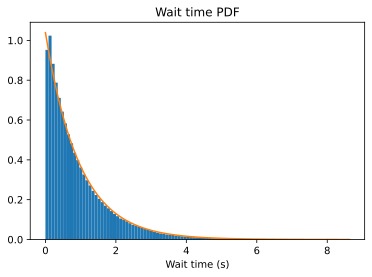

cdf [0.08717556250527986, 0.17435112501055972, 0.2615266875158396, 0.34870225002111943, 0.4358778125263993, 0.5230533750316791, 0.610228937536959, 0.6974045000422389, 0.7845800625475188, 0.8717556250527986] [0.08301293254106955, 0.17226650737921714, 0.24920051959705142, 0.3178671480069071, 0.37987839550934593, 0.4358328942494796, 0.48666054557690397, 0.5326939229055699, 0.5748342349768111, 0.6128062935932014]


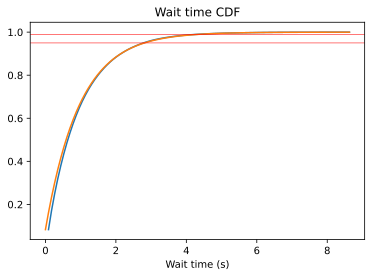

Arrival rate: 7.986433331145641
CV arrival: 2.00104821739692
Mean wait time: 0.8855430283137772
Kingman's prediction: 0.7940940984928216
zero_percentage 1.939631812477138e-05


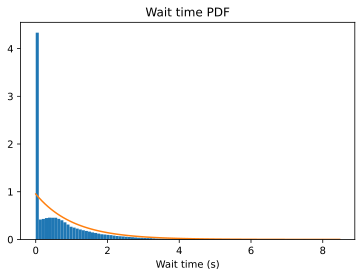

cdf [0.08555647998663415, 0.1711129599732683, 0.25666943995990243, 0.3422259199465366, 0.4277823999331708, 0.5133388799198049, 0.598895359906439, 0.6844518398930732, 0.7700083198797074, 0.8555647998663416] [0.37074930443732673, 0.40639892616642914, 0.4431879934988993, 0.481569780400033, 0.5206753030800091, 0.5595642058815427, 0.5985420104828995, 0.6353936847166536, 0.6697285615187932, 0.7004297337704128]


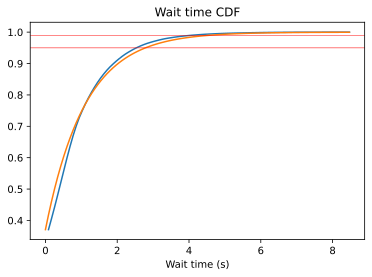

Arrival rate: 7.986433331145641
CV arrival: 2.00104821739692
Mean wait time: 0.6922984792731534
Kingman's prediction: -2.288666237650761


In [42]:
_, _, _, _, _, cdfx1, cdfy1 = get_arrival_statistics(arrivals, processing_latency)
_, _, _, _, _, cdfx10, cdfy10 = get_arrival_statistics(arrivals, processing_latency * 10, n_servers=10)

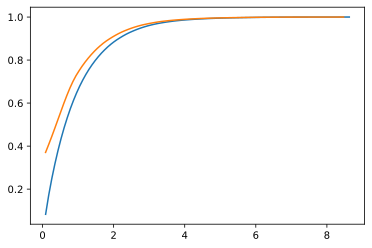

In [43]:
plt.plot(cdfx1, cdfy1)
plt.plot(cdfx10, cdfy10)

zero_percentage 1.3006386621663396e-05


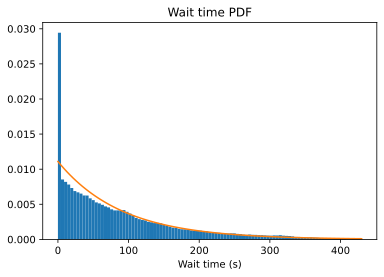

cdf [4.342252134068662, 8.684504268137324, 13.026756402205987, 17.36900853627465, 21.71126067034331, 26.053512804411973, 30.395764938480635, 34.7380170725493, 39.080269206617956, 43.42252134068662] [0.12782106133502028, 0.164879832636912, 0.2004444888378365, 0.2343596530656412, 0.2661397725948493, 0.2960151381466869, 0.3251274922727752, 0.3534477018095856, 0.3806261687947749, 0.40776162968142193]


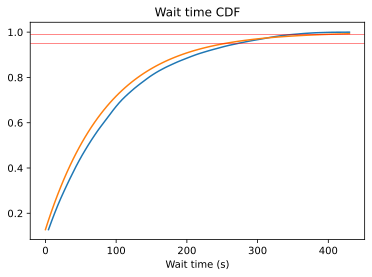

Arrival rate: 7.905374154832799
CV arrival: 1.7054929761381337
Mean wait time: 77.3657834955107
Kingman's prediction: -0.7914440728335115


In [25]:
_ = get_arrival_statistics(arrivals, processing_latency * 2, n_servers=2)

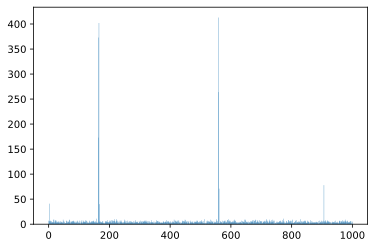

In [12]:
_ = plt.hist(arrivals, bins=np.linspace(0, 1000, 1000))

zero_percentage 3.342915860764132e-05


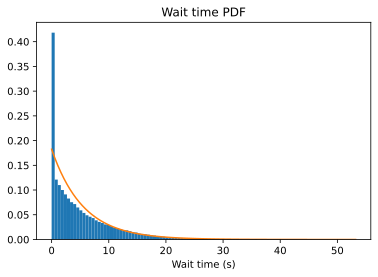

cdf [0.5372768953809752, 1.0745537907619505, 1.6118306861429257, 2.149107581523901, 2.686384476904876, 3.2236613722858514, 3.760938267666827, 4.298215163047802, 4.835492058428777, 5.372768953809752] [0.22474394158263827, 0.28977383989715094, 0.3488978632709068, 0.40266090742164995, 0.4516135440641842, 0.4961218750088688, 0.5366030860396015, 0.5750721561126232, 0.609888722077642, 0.6415636236700429]


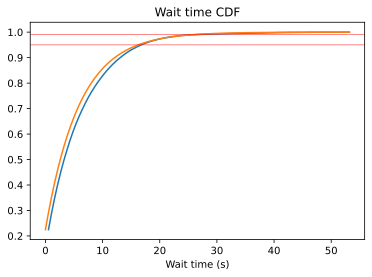

Arrival rate: 7.240702768899635
CV arrival: 1.508820658952038
Mean wait time: 4.586428574360882
Kingman's prediction: 0.2986946768391072


In [33]:
model_names, model_arrivals = generate_uniform_mmpp_arrivals(
    num_models=1, num_requests=400000, state_durations=(10, 1), state_request_rates=(4, 40), seed=2)
arrivals = np.array(model_arrivals["m0"])
processing_latency = 0.1
_ = get_arrival_statistics(arrivals, processing_latency)

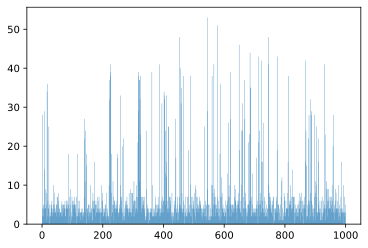

In [14]:
_ = plt.hist(arrivals, bins=np.linspace(0, 1000, 1000))

zero_percentage 1.6504822836742007e-05


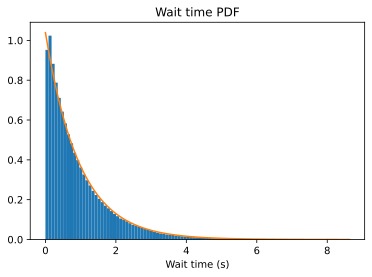

cdf [0.08717556250527986, 0.17435112501055972, 0.2615266875158396, 0.34870225002111943, 0.4358778125263993, 0.5230533750316791, 0.610228937536959, 0.6974045000422389, 0.7845800625475188, 0.8717556250527986] [0.08301293254106955, 0.17226650737921714, 0.24920051959705142, 0.3178671480069071, 0.37987839550934593, 0.4358328942494796, 0.48666054557690397, 0.5326939229055699, 0.5748342349768111, 0.6128062935932014]


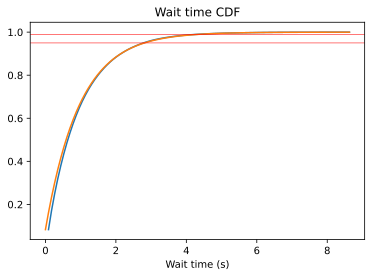

Arrival rate: 7.986433331145641
CV arrival: 2.00104821739692
Mean wait time: 0.8855430283137772
Kingman's prediction: 0.7940940984928216


In [41]:
model_names, model_arrivals = generate_gamma_arrivals(
    num_models=1, average_rate=8, cv=2, duration=100000, seed=2)
arrivals = np.array(model_arrivals["m0"])
processing_latency = 0.1
_ = get_arrival_statistics(arrivals, processing_latency)

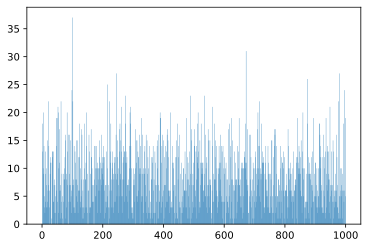

In [16]:
_ = plt.hist(arrivals, bins=np.linspace(0, 1000, 1000))

# Sketch

In [ ]:
import pickle
from alpa_serve.profiling import ParallelConfig
from alpa_serve.placement_policy import ModelParallelismPlacement
import numpy as np

In [ ]:
result = pickle.load(open("profiling_result.pkl", "rb"))

In [ ]:
latency_8stages = np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 8)].latency[1])

In [ ]:
latency_8stages.max() * 8

In [ ]:
latency_1stage = np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 1)].latency[1])

In [ ]:
latency_1stage

In [ ]:
0.12776608 / 0.0996182

In [ ]:
np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 4)].latency[1]).max() * 4

In [ ]:
0.10797936 / 0.0996182

In [ ]:
def compute_capability(slo, profile_result, parallel_config):
    slo = slo
    latency_mem = profile_result.para_dict.get(parallel_config, None)

    if latency_mem is None:
        return 0

    num_stages = parallel_config.pp
    max_cap = 0
    max_bs = 1
    for b, ls in latency_mem.latency.items():
        if b > max_bs:
            continue

        # slo = sum(ls) + (n-1) * max(ls)
        # so, n = ceil((slo - sum(ls)) / max(ls)) + 1
        max_cap = max(max_cap, (slo - sum(ls)) // max(ls) + 1)

    return max_cap


In [ ]:
slos = [0.1, 0.2, 0.4, 0.8, 1.0, 2.0, 4.0, 8.0]
for slo in slos:
    for pp in [1, 2, 4, 8]:
        print("slo", slo, "pp", pp, compute_capability(slo, result['bert-1.3b'], ParallelConfig(1, 1, pp)))

In [ ]:
# slo 0.8 pp 1 8.0
# slo 0.8 pp 2 15.0
# slo 0.8 pp 4 26.0
# slo 0.8 pp 8 44.0
# slo 1.0 pp 1 10.0
# slo 1.0 pp 2 19.0
# slo 1.0 pp 4 34.0
# slo 1.0 pp 8 56.0

# SLO 0.8: Optimal case
# ModelParallelismPlacement([(ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]), 
#                            (ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15])])
obj_optimal = 26 * 2
obj_non_optimal = 26
# SLO 1.0: Optimal case
# ModelParallelismPlacement([(ParallelConfig(dp=1, op=1, pp=2), [0, 7, 9, 10, 11, 12, 13]), 
#                            (ParallelConfig(dp=1, op=1, pp=1), [7, 11, 12]), 
#                            (ParallelConfig(dp=1, op=1, pp=1), [2, 5, 7]), 
#                            (ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15])])
obj_optimal = 34.0 * 2
obj_non_optimal = 34.0

In [ ]:
result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 1)].weight_mem

In [ ]:
from alpa_serve.util import GB

In [ ]:
10*GB

In [ ]:
40 / (2838835202.8206697 / GB)

In [ ]:
len([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15])